# Install Libraries

In [1]:
!pip install transformers

# !pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 73.3 MB/s eta 0:00:00


# Packages

In [2]:
import torch
import transformers
import spacy
import numpy as np
import json,time
from pathlib import Path
from tqdm import tqdm

In [3]:
# creates a torch.device object that represents the device (GPU or CPU) on which the computation will be executed.

device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

In [4]:
# Load BERT-base-uncased model and tokenizer

model = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=8).to(device)
# model = transformers.BertForQuestionAnswering.from_pretrained('bert-base-uncased', num_labels=8).to(device)
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

# Loading SquadV2 Dataset

In [5]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# Load SQuAD v2 dataset and preprocess data

!mkdir squadV2_ds
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squadV2_ds/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squadV2_ds/dev-v2.0.json

--2023-03-07 10:09:53--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘squadV2_ds/train-v2.0.json’

squadV2_ds/train-v2 100%[===================>]  40.17M   177MB/s    in 0.2s    

2023-03-07 10:09:54 (177 MB/s) - ‘squadV2_ds/train-v2.0.json’ saved [42123633/42123633]

--2023-03-07 10:09:54--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘squadV2_ds/dev-

# Retrieve and Store the data

In [6]:
# Give the path for train data
path = Path('/content/squadV2_ds/train-v2.0.json')

# Open .json file
with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

# Search for each passage, its question and its answer
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                # Store every passage, query and its answer to the lists
                texts.append(context)
                queries.append(question)
                answers.append(answer['text'])

passages_train, questions_train, answers_train = texts, queries, answers

In [7]:
# Give the path for train data
path = Path('/content/squadV2_ds/dev-v2.0.json')

# Open .json file
with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

# Search for each passage, its question and its answer
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                # Store every passage, query and its answer to the lists
                texts.append(context)
                queries.append(question)
                answers.append(answer['text'])

passages_val, questions_val, answers_val = texts, queries, answers

In [8]:
# passages = passages[:1000]
# questions = questions[:1000]
# answers = answers[:1000]
print(len(passages_train))
print(len(questions_train))
print(len(answers_train))

print("Passage: ",passages_train[0])  
print("Query: ",questions_train[0])
print("Answer: ",answers_train[0])

# print(questions[0].split(" ", 1)[0])

86821
86821
86821
Passage:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Query:  When did Beyonce start becoming popular?
Answer:  in the late 1990s


In [9]:
# passages = passages[:1000]
# questions = questions[:1000]
# answers = answers[:1000]
print(len(passages_val))
print(len(questions_val))
print(len(answers_val))

print("Passage: ",passages_val[0])  
print("Query: ",questions_val[0])
print("Answer: ",answers_val[0])

# print(questions[0].split(" ", 1)[0])

20302
20302
20302
Passage:  The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Query:  In what country is Normandy located?
Answer:  France


# Tokenization 







In [10]:
# training data tokenization

input_ids_train = []
attention_masks_train = []

# iterates through pairs of passages and answers and calls tokenizer.encode_plus() on each pair.
# tokenizes a piece of text(passages, answers) and returns a dictionary containing various pieces of information about the tokens.
''' 
  the resulting dictionary contains two keys: input_ids and attention_mask. 
  input_ids is a tensor that contains the token IDs of the input sequence,
  and attention_mask is a tensor that contains a binary mask indicating which tokens are padding and which ones are not.
'''
for passage, answer in zip(passages_train, answers_train):
    encoded_dict = tokenizer.encode_plus(
                        answer,
                        passage,
                        add_special_tokens = True,
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )
    input_ids_train.append(encoded_dict['input_ids'])
    attention_masks_train.append(encoded_dict['attention_mask'])


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs w

In [11]:
# validation data tokenization


input_ids_val = []
attention_masks_val = []

for passage, answer in zip(passages_val, answers_val):
    encoded_dict = tokenizer.encode_plus(
                        answer,
                        passage,
                        add_special_tokens = True,
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )
    input_ids_val.append(encoded_dict['input_ids'])
    attention_masks_val.append(encoded_dict['attention_mask'])

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

# Entity Name Recognition

In [19]:
# Obtain entity type of answer using spaCy and create learnable embedding

nlp = spacy.load('en_core_web_sm')
entity_types = []
for answer in tqdm(answers_train):
    doc = nlp(answer)
    if doc.ents:
        entity_types.append(doc.ents[0].label_)
    else:
        entity_types.append('None')


# printing frequancy of each label in dataset
print('label     :   frequance')
for label in nlp.get_pipe("ner").labels:
  print(label,"  :  ",entity_types.count(label))
print('None',"   :  ",entity_types.count('None'))


# create array for each entity 
entity_type_embeddings_train = np.zeros((len(entity_types), 5))

# dictionary to map each entity to its tensor
entity_type_dict = {'PERSON': [1, 0, 0, 0, 0], 'CARDINAL': [0, 1, 0, 0, 0], 'DATE': [0, 0, 1, 0, 0], 'ORG': [0, 0, 0, 1, 0], 'GPE': [0, 0, 0, 0, 1], 'None': [0, 0, 0, 0, 0]}


for i, entity_type in enumerate(entity_types):
    try:
      entity_type_embeddings_train[i] = np.array(entity_type_dict[entity_type])
    except:  
      entity_type_embeddings_train[i] = np.array(entity_type_dict['None'])

100%|██████████| 86821/86821 [09:31<00:00, 151.96it/s]


label     :   frequance
CARDINAL   :   8368
DATE   :   9959
EVENT   :   308
FAC   :   326
GPE   :   5792
LANGUAGE   :   235
LAW   :   121
LOC   :   711
MONEY   :   814
NORP   :   3390
ORDINAL   :   744
ORG   :   10792
PERCENT   :   1312
PERSON   :   7732
PRODUCT   :   383
QUANTITY   :   439
TIME   :   216
WORK_OF_ART   :   242
None    :   34937


In [20]:
# Obtain entity type of answer using spaCy and create learnable embedding

nlp = spacy.load('en_core_web_sm')
entity_types = []
for answer in tqdm(answers_val):
    doc = nlp(answer)
    if doc.ents:
        entity_types.append(doc.ents[0].label_)
    else:
        entity_types.append('None')


# printing frequancy of each label in dataset
print('label     :   frequance')
for label in nlp.get_pipe("ner").labels:
  print(label,"  :  ",entity_types.count(label))
print('None',"   :  ",entity_types.count('None'))


# create array for each entity 
entity_type_embeddings_val = np.zeros((len(entity_types), 5))

# dictionary to map each entity to its tensor
entity_type_dict = {'PERSON': [1, 0, 0, 0, 0], 'CARDINAL': [0, 1, 0, 0, 0], 'DATE': [0, 0, 1, 0, 0], 'ORG': [0, 0, 0, 1, 0], 'GPE': [0, 0, 0, 0, 1], 'None': [0, 0, 0, 0, 0]}


for i, entity_type in enumerate(entity_types):
    try:
      entity_type_embeddings_val[i] = np.array(entity_type_dict[entity_type])
    except:  
      entity_type_embeddings_val[i] = np.array(entity_type_dict['None'])

100%|██████████| 20302/20302 [02:10<00:00, 156.05it/s]


label     :   frequance
CARDINAL   :   1707
DATE   :   1866
EVENT   :   59
FAC   :   71
GPE   :   1213
LANGUAGE   :   37
LAW   :   26
LOC   :   268
MONEY   :   143
NORP   :   693
ORDINAL   :   132
ORG   :   2202
PERCENT   :   223
PERSON   :   1473
PRODUCT   :   77
QUANTITY   :   158
TIME   :   24
WORK_OF_ART   :   41
None    :   9889


# FeedForward Network

In [21]:
class FFN(torch.nn.Module):
    def __init__(self, hidden_size, num_classes):
        super().__init__()
        self.fc1 = torch.nn.Linear(hidden_size, num_classes).to(device)
        self.softmax = torch.nn.Softmax(dim=-1).to(device)

    def forward(self, x):
        out = self.fc1(x)
        out = self.softmax(out)
        return out

# Extract Question Word 

In [22]:
# dictionary to map each token
interrogative_words = {'who':0, 'what':1, 'when':2, 'where':3, 'why':4, 'how':5,'which':6,'other':7}

found_interrogative_words_train = []
for q in tqdm(questions_train):
  words = tokenizer.tokenize(q)
  for word in words:
    found=False
    if word.lower() in interrogative_words:
        found=True
        found_interrogative_words_train.append(interrogative_words[word.lower()])
        break
  if found==False:
        found_interrogative_words_train.append(interrogative_words['other'])

100%|██████████| 86821/86821 [00:39<00:00, 2188.71it/s]


In [23]:
# dictionary to map each token
interrogative_words = {'who':0, 'what':1, 'when':2, 'where':3, 'why':4, 'how':5,'which':6,'other':7}

found_interrogative_words_val = []
for q in tqdm(questions_val):
  words = tokenizer.tokenize(q)
  for word in words:
    found=False
    if word.lower() in interrogative_words:
        found=True
        found_interrogative_words_val.append(interrogative_words[word.lower()])
        break
  if found==False:
        found_interrogative_words_val.append(interrogative_words['other'])

100%|██████████| 20302/20302 [00:10<00:00, 2020.40it/s]


In [26]:
# Convert data to tensors 

input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)
entity_type_embeddings_train = torch.from_numpy(entity_type_embeddings_train)
interrogative_words_labels_train=torch.tensor(found_interrogative_words_train,dtype=torch.int64)

# print(input_ids.shape)
# print(len(entity_type_embeddings))
# print(len(interrogative_words_labels))

input_ids_val = torch.cat(input_ids_val, dim=0)
attention_masks_val = torch.cat(attention_masks_val, dim=0)
entity_type_embeddings_val = torch.from_numpy(entity_type_embeddings_val)
interrogative_words_labels_val=torch.tensor(found_interrogative_words_val,dtype=torch.int64)

# Loading Data to TensorDataset 

In [28]:
dataset_train = torch.utils.data.TensorDataset(input_ids_train, attention_masks_train, entity_type_embeddings_train,interrogative_words_labels_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=4,shuffle=True, num_workers=8, pin_memory=True,sampler=None)

dataset_val = torch.utils.data.TensorDataset(input_ids_val, attention_masks_val, entity_type_embeddings_val,interrogative_words_labels_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=4,shuffle=True, num_workers=8, pin_memory=True,sampler=None)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Base Model

In [ ]:
# Train the model on the SQuAD v2 dataset
ffn = FFN(hidden_size=773, num_classes=8)
optimizer = torch.optim.Adam(ffn.parameters(), lr=5e-5, weight_decay=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 3

train_losses = []
val_losses = []

print_every = 1000

for epoch in tqdm(range(epochs)):
    epoch_time = time.time()

    # Set model in train mode
    model.train()
    
    loss_of_epoch = 0
    print("\n############Train############")

    for batch_idx,batch in enumerate(dataloader_train):
      
        optimizer.zero_grad()
        input_ids_batch, attention_masks_batch, entity_type_embeddings_batch,labels= tuple(t.to(device) for t in batch)  #change t.to(device)
        outputs = model(input_ids_batch, attention_mask=attention_masks_batch, labels=labels,output_hidden_states=True)

        cls_tensor = outputs.hidden_states[-1]
        # https://discuss.huggingface.co/t/how-to-get-cls-embeddings-from-bertfortokenclassification-model/9276/2#:~:text=The%20shape%20of%20last_hidden_states%20will%20be%20%5Bbatch_size%2C%20tokens%2C%20hidden_dim%5D%20so%20if%20you%20want%20to%20get%20the%20embedding%20of%20the%20first%20element%20in%20the%20batch%20and%20the%20%5BCLS%5D%20token%20you%20can%20get%20it%20with%20last_hidden_states%5B0%2C0%2C%3A%5D.
        cls_tensor = cls_tensor[:,0,:]
        cls_tensor = cls_tensor
        ner_tensor = entity_type_embeddings_batch.to(torch.float32)

        # Concatenate the tensors along the first dimension
        concat_tensor = torch.cat((cls_tensor, ner_tensor),dim=1).to(device)

        logits = ffn(concat_tensor)
        predictions = torch.argmax(logits, dim=1)

        
        loss = loss_fn(predictions.float(), labels.float())
        loss.requires_grad = True
        loss.backward()
        optimizer.step()
        loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
          print("Batch {:} / {:}".format(batch_idx+1,len(dataloader_train)),"\nLoss:", round(loss.item(),1),"\n")

        del batch, concat_tensor
        torch.cuda.empty_cache()

    loss_of_epoch /= len(dataloader_train)
    train_losses.append(loss_of_epoch)  

    model.eval()

    print("\n############Evaluate############")

    loss_of_epoch = 0

    for batch_idx,batch in enumerate(dataloader_val):
        optimizer.zero_grad()
        input_ids_batch, attention_masks_batch, entity_type_embeddings_batch,labels= tuple(t.to(device) for t in batch)  #change t.to(device)
        outputs = model(input_ids_batch, attention_mask=attention_masks_batch, labels=labels,output_hidden_states=True)

        cls_tensor = outputs.hidden_states[-1]
        # https://discuss.huggingface.co/t/how-to-get-cls-embeddings-from-bertfortokenclassification-model/9276/2#:~:text=The%20shape%20of%20last_hidden_states%20will%20be%20%5Bbatch_size%2C%20tokens%2C%20hidden_dim%5D%20so%20if%20you%20want%20to%20get%20the%20embedding%20of%20the%20first%20element%20in%20the%20batch%20and%20the%20%5BCLS%5D%20token%20you%20can%20get%20it%20with%20last_hidden_states%5B0%2C0%2C%3A%5D.
        cls_tensor = cls_tensor[:,0,:]
        cls_tensor = cls_tensor
        ner_tensor = entity_type_embeddings_batch.to(torch.float32)

        # Concatenate the tensors along the first dimension
        concat_tensor = torch.cat((cls_tensor, ner_tensor),dim=1).to(device)

        logits = ffn(concat_tensor)
        predictions = torch.argmax(logits, dim=1)

        
        loss = loss_fn(predictions.float(), labels.float())
        loss.requires_grad = True
        loss.backward()
        optimizer.step()
        loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
          print("Batch {:} / {:}".format(batch_idx+1,len(dataloader_val)),"\nLoss:", round(loss.item(),1),"\n")

        del batch, concat_tensor
        torch.cuda.empty_cache()

    loss_of_epoch /= len(dataloader_val)
    val_losses.append(loss_of_epoch)  


    print("\n-------Epoch ", epoch+1,
      "-------"
      "\n Training Loss:", train_losses[-1],
      "\n validation Loss:", train_losses[-1],
      "\n Time: ",(time.time() - epoch_time),
      '\n predictions :',predictions,
      '\n actual :',labels,
      "\n-----------------------","\n\n")

# Evaluate the model on the SQuAD v2 dataset
# model.eval()
# with torch.no_grad():
#     input_ids = []
#     attention_masks = []
#     entity

  0%|          | 0/3 [00:00<?, ?it/s]

############Train############
Batch 1000 / 21706 
Loss: 7.5 

Batch 2000 / 21706 
Loss: 18.6 

Batch 3000 / 21706 
Loss: 14.2 

Batch 4000 / 21706 
Loss: 10.8 

Batch 5000 / 21706 
Loss: 5.6 

Batch 6000 / 21706 
Loss: 16.8 

Batch 7000 / 21706 
Loss: 21.3 

Batch 8000 / 21706 
Loss: 3.3 

Batch 9000 / 21706 
Loss: 14.1 

Batch 10000 / 21706 
Loss: 26.9 

Batch 11000 / 21706 
Loss: 3.3 

Batch 12000 / 21706 
Loss: 9.7 

Batch 13000 / 21706 
Loss: 39.5 

Batch 14000 / 21706 
Loss: 9.0 

Batch 15000 / 21706 
Loss: 9.0 

Batch 16000 / 21706 
Loss: 9.7 

Batch 17000 / 21706 
Loss: 17.9 

Batch 18000 / 21706 
Loss: 15.7 

Batch 19000 / 21706 
Loss: 14.2 



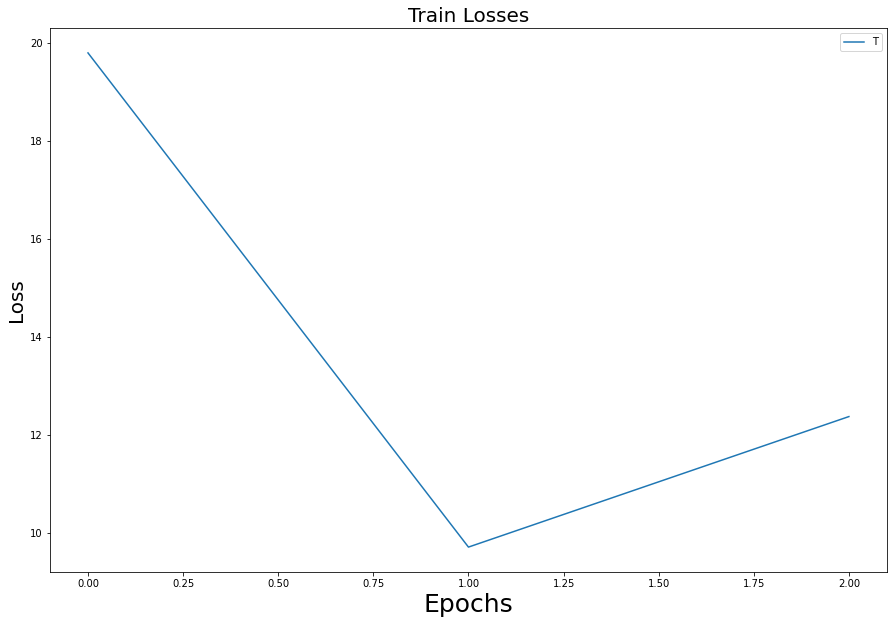

In [ ]:
import matplotlib.pyplot as plt 

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20) 
ax.set_xlabel('Epochs', fontsize = 25) 

_=ax.plot(train_losses)
# _=ax.plot(val_losses)
# _=ax.legend(('Train','Val'),loc='upper right')
_=ax.legend(('Train'),loc='upper right')